## Traininig of the High Level Feature classifier with TensorFlow/Keras

**4.0 Tensorflow/Keras, HLF classifier, PySpark and Keras** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses TensorFlow/Keras on a single node. Spark is used in local mode just to read the data and pass it to TensorFlow.

Credits: this notebook is part of the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger
- The model is a classifier implemented as a DNN
  - Model input: 14 "high level features", described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
  - Model output: 3 classes, "W + jet", "QCD", "$t\bar{t}$"

In [1]:
# No need to run this when using CERN SWAN service
# Just add the configuration parameters for Spark on the "star" button integration

# pip install pyspark or use your favorite way to set Spark Home, here we use findspark
import findspark
findspark.init('/home/luca/Spark/spark-3.3.2-bin-hadoop3') #set path to SPARK_HOME

# Create Spark session and configure according to your environment
from pyspark.sql import SparkSession

# Spark is used in local mode for this, just to fork data for HLF classifier (~ 300 MB)
spark = ( SparkSession.builder
          .appName("Training-RandomForestClassifier")
          .master("local[*]")
          .config("spark.driver.memory","2g")
          .config("spark.sql.execution.arrow.pyspark.enabled", "true")
          .config("spark.dynamicAllocation.enabled", "true")
          .config("spark.ui.showConsoleProgress", "false")
          .getOrCreate()
        )


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/10 19:19:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Check if Spark Session has been created correctly
spark

## Load train and test datasets via Spark

In [3]:
# Download the datasets from 
# ** https://github.com/cerndb/SparkDLTrigger/tree/master/Data **
#
# For CERN users, data is already available on EOS
PATH = "/eos/project/s/sparkdltrigger/public/"

# PATH = "../Data/sparkdltrigger.web.cern.ch/sparkdltrigger/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled_HLF_features.parquet')\
        .select(['HLF_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled_HLF_features.parquet')\
        .select(['HLF_input', 'encoded_label'])

In [4]:
# Check the number of events in the train and test datasets

num_test = testDF.count()
num_train = trainDF.count()

print('There are {} events in the test dataset'.format(num_test))
print('There are {} events in the train dataset'.format(num_train))

There are 856090 events in the test dataset
There are 3426083 events in the train dataset


In [5]:
# Show the schema and a data sample of the test dataset
testDF.printSchema()
testDF.limit(5).toPandas()

root
 |-- HLF_input: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- encoded_label: array (nullable = true)
 |    |-- element: double (containsNull = true)



,HLF_input,encoded_label
0,"[0.015150733133517018, 0.003511028294205839, 0...","[1.0, 0.0, 0.0]"
1,"[0.0, 0.003881822832783805, 0.7166341448458555...","[1.0, 0.0, 0.0]"
2,"[0.009639073600865505, 0.0010022659022912096, ...","[1.0, 0.0, 0.0]"
3,"[0.016354407625436572, 0.002108937905084598, 0...","[1.0, 0.0, 0.0]"
4,"[0.01925979125354152, 0.004603697276827594, 0....","[1.0, 0.0, 0.0]"


## Convert training and test datasets from Spark DataFrames to Numpy arrays

Now we will collect and convert the Spark DataFrame into numpy arrays in order to be able to feed them to TensorFlow/Keras.
We use the "spark.sql.execution.arrow.pyspark.enabled" toPandas optimization in Spark to move data faster bewteen JVM and Python.


In [6]:
import numpy as np

trainPDF=trainDF.toPandas()
testPDF=testDF.toPandas()

X = np.stack(trainPDF["HLF_input"])
y = np.stack(trainPDF["encoded_label"])

X_test = np.stack(testPDF["HLF_input"])
y_test = np.stack(testPDF["encoded_label"])

## Create the Keras model

In [8]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [9]:
# Check that we have a GPU available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

keras_model = create_model(50,20,10)

2023-03-10 19:21:20.503728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 19:21:21.045904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3312 MB memory:  -> device: 0, name: Quadro K2200, pci bus id: 0000:02:00.0, compute capability: 5.0


## Train the model

In [11]:
batch_size = 128
n_epochs = 5

%time history = keras_model.fit(X, y, batch_size=batch_size, epochs=n_epochs, \
                                validation_data=(X_test, y_test))

Epoch 1/5


2023-03-10 19:22:17.702568: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f98200150a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-10 19:22:17.702629: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro K2200, Compute Capability 5.0
2023-03-10 19:22:17.715065: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-10 19:22:18.328517: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26767/26767 [==============================] - 63s 2ms/step - loss: 0.2814 - accuracy: 0.8967 - val_loss: 0.2494 - val_accuracy: 0.9081
Epoch 2/5
26767/26767 [==============================] - 59s 2ms/step - loss: 0.2447 - accuracy: 0.9095 - val_loss: 0.2367 - val_accuracy: 0.9126
Epoch 3/5
26767/26767 [==============================] - 59s 2ms/step - loss: 0.2358 - accuracy: 0.9127 - val_loss: 0.2337 - val_accuracy: 0.9138
Epoch 4/5
26767/26767 [==============================] - 59s 2ms/step - loss: 0.2323 - accuracy: 0.9140 - val_loss: 0.2348 - val_accuracy: 0.9131
Epoch 5/5
26767/26767 [==============================] - 59s 2ms/step - loss: 0.2300 - accuracy: 0.9148 - val_loss: 0.2280 - val_accuracy: 0.9158
CPU times: user 7min 2s, sys: 38 s, total: 7min 40s
Wall time: 4min 59s


## Performance metrics

<IPython.core.display.Javascript object>


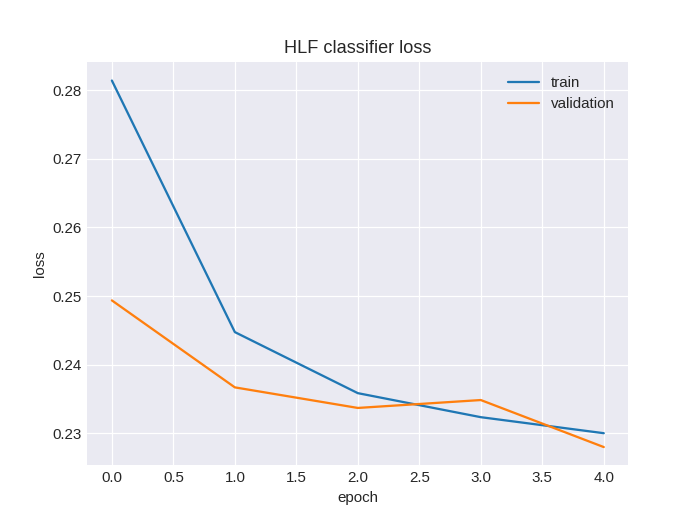

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


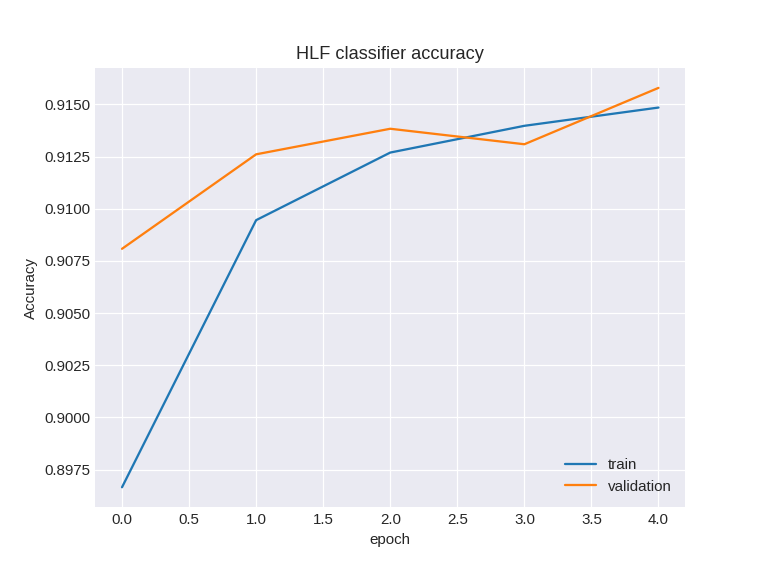

In [13]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [14]:
y_pred=history.model.predict(X_test)
y_true=y_test

26753/26753 [==============================] - 24s 897us/step


In [15]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9158


<IPython.core.display.Javascript object>


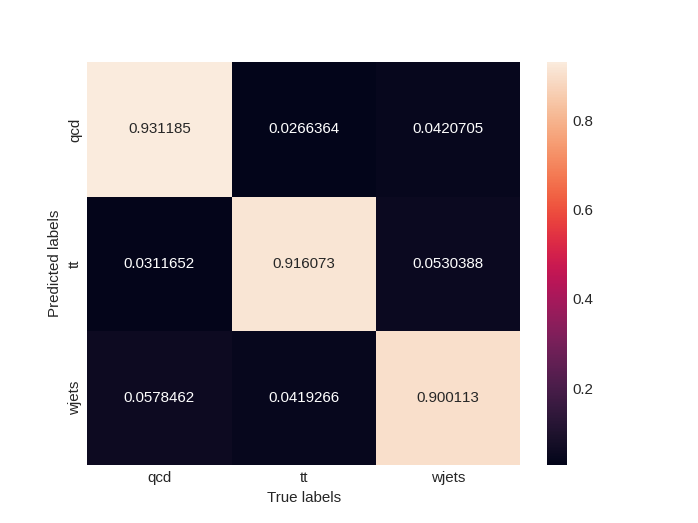

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [17]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [18]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9873925298484194, 1: 0.9855455868794855, 2: 0.9812856501713125}

<IPython.core.display.Javascript object>


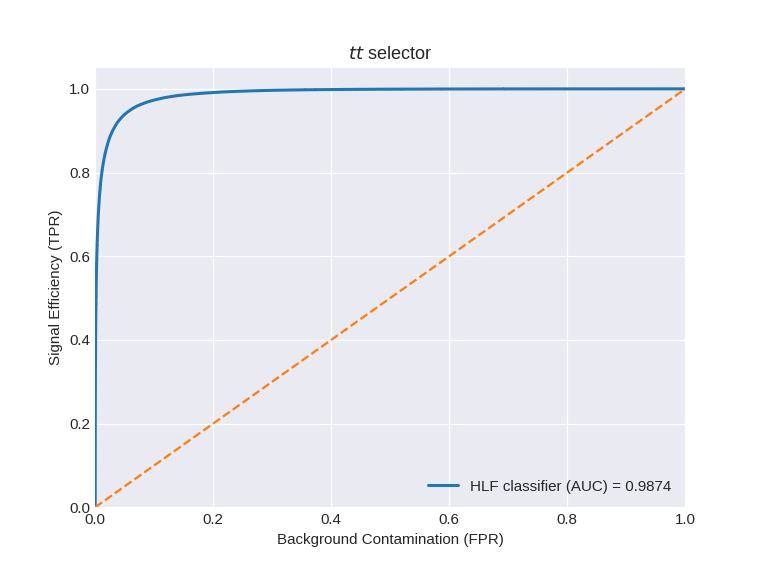

In [19]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, \
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()

In [20]:
spark.stop()